In [2]:
%automagic


Automagic is ON, % prefix IS NOT needed for line magics.


In [1]:
# import relevant packages

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set up data directory

dirData = "data/"

# initialize input/output file names and paths to be used

fileInputTrn = 'download/train.csv'
fileInputTrx = 'download/transactions.csv'
fileInputReg = 'download/members_v3.csv'
fileInputUsg = 'download/user_logs.csv'

fileSampleTrn = 'sample/trn_smpl.csv'
fileSampleTrx = 'sample/trx_smpl.csv'
fileSampleReg = 'sample/reg_smpl.csv'
fileSampleUsg = 'sample/usg_smpl.csv'

fileCleanTrx = 'trx_clean.csv'
fileCleanReg = 'reg_clean.csv'
fileCleanUsg = 'usg_daily_clean.csv'
fileDates = 'dates.csv'

fileLastTrx = 'last_trx.csv'
fileUsgAggLifetime = 'usg_agg_lifetime.csv'
fileUsgAggPeriods = 'usg_agg_periods.csv'

fileDnrm = 'denorm_data.csv'

In [2]:
# a demo user used to see sample data along the transformations

demUsr = '3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE='

## Data Sampling

Since the usage data is way too huge for PC memory to store in pandas dataframe, I am randomly sampling it down to a manageable set.

In [2]:
# sample size - number of users from ~1mn users available in training dataset
# to restrict the data analysis and training model on

nSample = 150000

In [3]:
# generate sample users out of training dataset - labeled data having churn behavior

dfInputTrn = pd.read_csv("{}/{}".format(dirData, fileInputTrn))
dfInputTrn.columns = ['msno','churn']

train = dfInputTrn.sample(nSample, random_state=101)

# dump into a file for later use

train.to_csv("{}/{}".format(dirData, fileSampleTrn), index=False)

# delete the dataframe to free up memory

del(dfInputTrn)

In [5]:
# extract sample subscription/sales transactions for users in scope (i.e. in sample labeled dataset)

trx = pd.read_csv("{}/{}".format(dirData, fileInputTrx), parse_dates=['transaction_date','membership_expire_date'])
trx = pd.merge(trx, train, on='msno', how='inner')
trx.columns = ['msno', 'payMethod', 'planTerm', 'planListPrice', 'paidAmt', 'autoRenew',
               'trxDate', 'expDate', 'cancel', 'churn']

# dump into a file for later use

trx.to_csv("{}/{}".format(dirData, fileSampleTrx), index=False)

# takes 10 min to run through, yielding 2.4mn records out of 22mn transactions

In [9]:
# extract sample registration/membership data for users in scope (i.e. in sample labeled data)

reg = pd.read_csv("{}/{}".format(dirData, fileInputReg), parse_dates=['registration_init_time'])
reg.columns = ['msno', 'city', 'userAge', 'gender', 'regSrc','regDate']

reg = pd.merge(reg, train, on='msno', how='inner')

# dump into a file for later use

reg.to_csv("{}/{}".format(dirData, fileSampleReg), index=False)

# takes 1 min to run through, yielding 132k records out of 7mn registrations
# notice that we do not have registration data available for all the 150k users - 18k users are missing

In [12]:
# extract sample daily usage data for users in scope (i.e. in sample labeled data)

# chunksize of 5mn not causing any memory shortage problems while processing
FileReader = pd.read_csv("{}/{}".format(dirData, fileInputUsg), chunksize=5000000, parse_dates=['date'])

# create a loop to iterate over 400mn usage dataset

n = 1

for chdf in FileReader:
    
    chdf = pd.merge(chdf, train, on='msno', how='inner')
    chdf['total_secs'] = chdf['total_secs'].round().astype(int)
    
    if n==1:
        df = chdf.copy()
    else:
        df = pd.concat([df, chdf], axis=0, sort=False)
    
    if n%5==0: print("{} iteration done; moving on...".format(n))
    
    n += 1

print("Data sampling finished.")
print("Starting with data dumping...")

# dump into a file for later use

df.sort_values(['msno','date']).to_csv("{}/{}".format(dirData, fileSampleUsg), index=False)

print("Data dumping completed.")

# takes around 1.5 hrs to run through, yielding 37mn records out of 400mn usage data

5 iteration done; moving on...
10 iteration done; moving on...
15 iteration done; moving on...
20 iteration done; moving on...
25 iteration done; moving on...
30 iteration done; moving on...
35 iteration done; moving on...
40 iteration done; moving on...
45 iteration done; moving on...
50 iteration done; moving on...
55 iteration done; moving on...
60 iteration done; moving on...
65 iteration done; moving on...
70 iteration done; moving on...
75 iteration done; moving on...
Data sampling finished.
Starting with data dumping...
Data dumping completed.


## Data Quality

### Sample Data Extraction

In [3]:
# extract sample users in scope of data analysis/model training

train = pd.read_csv("{}/{}".format(dirData, fileSampleTrn))
train.head(2)

,msno,churn
0,6zAmmLkBpc1IOiXONsdDrMXyD4gvnvpWisFc810jbjE=,0
1,+ATq+FuiI5u1H1lipgStq8k7vx+bfcLYmGmucjVjyiI=,0


In [4]:
# distribution of churn vs. renew users in sample labeled dataset

train['churn'].value_counts(normalize=True)

0    0.935687
1    0.064313
Name: churn, dtype: float64

In [5]:
# extract raw subscription transactions for sample users

trx = pd.read_csv("{}/{}".format(dirData, fileSampleTrx), parse_dates=['trxDate','expDate'])

In [6]:
trx[trx['msno']==demUsr].sort_values(['trxDate','expDate']).head(3)

,msno,payMethod,planTerm,planListPrice,paidAmt,autoRenew,trxDate,expDate,cancel,churn
1485772,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,41,30,99,99,1,2016-03-14,2016-04-13,0,0
1485778,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,41,30,99,99,1,2016-04-13,2016-05-13,0,0
1485773,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,41,30,99,99,1,2016-05-13,2016-06-13,0,0


In [7]:
# extract raw registration/membership data for sample users

reg = pd.read_csv("{}/{}".format(dirData, fileSampleReg), parse_dates=['regDate'])

In [8]:
reg[reg['msno']==demUsr]

,msno,city,userAge,gender,regSrc,regDate,churn
46834,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,6,47,female,7,2013-05-15,0


In [3]:
# extract raw daily usage data for sample users

df = pd.read_csv("{}/{}".format(dirData, fileSampleUsg), parse_dates=['date'])
df.head(2)

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,churn
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2015-01-01,3,3,2,2,6,16,2269,0
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2015-01-02,11,1,2,3,15,26,5174,0


In [4]:
df[df['msno']==demUsr].head(3)

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,churn
3117978,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,2016-04-21,5,0,1,0,6,10,2098,0
3117979,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,2016-04-23,0,0,0,0,9,9,2459,0
3117980,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,2016-04-25,0,0,0,0,8,8,2256,0


In [5]:
# save minimum and maximum dates from sample usage dataset

startDate = df['date'].min()
currDate = df['date'].max()

print(startDate, currDate)

2015-01-01 00:00:00 2017-02-28 00:00:00


In [6]:
# create a datetime dimension dataset for the given date range

dates = pd.DataFrame(pd.date_range(startDate,currDate).sort_values())
dates.columns=['date']

# custom function to derive month value that aligns with year change
# notice the special handling of dates just before end of and after start of new year
def iso_month(date):
    if date.month==1 or date.month==12:
        if date.month==1:
            if date.day<7 and date.week>=52:
                return(12)
            else:
                return(1)
        else:
            if date.month==12:
                if date.day>25 and date.week==1:
                    return(1)
                else:
                    return(12)
    else:
        return(date.month)

# get ISO calendar year
# starts only on the first Monday of the calendar year
dates['year'] = dates['date'].apply(lambda x: x.isocalendar()[0])

# derive month value (aligned with ISO calendar year and week at the start and the end of the year)
dates['month'] = dates['date'].apply(iso_month)

# ISO calendar week numbered from 1 to 52/53
# ISO week value changes only on a Monday irrespective of whether the calendar month/year changes or not
dates['week'] = dates['date'].dt.week

# derive day of the week, numbered from 1 to 7
# add 1 to ensure that Monday, which is the start of the week, is numbered as 1 (not 0)
dates['dayofweek'] = dates['date'].dt.weekday+1  

# name of the day
dates['dayname'] = dates['date'].dt.day_name()

# if the days fall over the weekend then mark them as 1
dates['weekend'] = dates['dayname'].apply(lambda x: 1 if (x=='Saturday' or x=='Sunday') else 0)

# year-month combination
dates['yrMth'] = (dates['year'].apply(str) + dates['month'].apply(str).str.pad(2, side='left', fillchar='0')).apply(int)

# year-week combination
dates['yrWk'] = (dates['year'].apply(str) + dates['week'].apply(str).str.pad(2, side='left', fillchar='0')).apply(int)

# output the dates data into a file for later use
dates.to_csv("{}/{}".format(dirData, fileDates), index=False)

dates.head(2)

,date,year,month,week,dayofweek,dayname,weekend,yrMth,yrWk
0,2015-01-01,2015,1,1,4,Thursday,0,201501,201501
1,2015-01-02,2015,1,1,5,Friday,0,201501,201501


### DQ Assessment & Data Cleaning

In [17]:
# number of records in each raw feed for sample users

train['msno'].count(), trx['msno'].count(), reg['msno'].count(), df['msno'].count()

(150000, 2401222, 132507, 37112323)

In [18]:
# number of distinct users in each raw feed for sample users

train['msno'].nunique(), trx['msno'].nunique(), reg['msno'].nunique(), df['msno'].nunique()

(150000, 150000, 132507, 131428)

Since registration and usage feeds do not have data for all the sample users, we might need to create a model using only the users for which registration and/or usage data are available.

In [19]:
# save number of unique users in separate variables

regUsrs = pd.DataFrame(reg['msno'].unique(), columns=['msno'])
usgUsrs = pd.DataFrame(df['msno'].unique(), columns=['msno'])

In [20]:
# number of users that are common across both the sample datasets - registration and usage

usgUsrs[usgUsrs['msno'].isin(regUsrs['msno'])]['msno'].nunique()

131427

In [21]:
# number of users that are present in usage and not in registration

usgUsrs[~usgUsrs['msno'].isin(regUsrs['msno'])]['msno'].nunique()

1

In [22]:
# number of users that are present in usage and not in registration

regUsrs[~regUsrs['msno'].isin(usgUsrs['msno'])]['msno'].nunique()

1080

#### Training Data (aka Labeled Data)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
msno     150000 non-null object
churn    150000 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


#### Transaction Data

In [24]:
# sort records based on user id, transaction date and expiry date
# will come handy during data profiling/wrangling later

trx = trx.sort_values(['msno','trxDate','expDate'])

trx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401222 entries, 1015697 to 1798806
Data columns (total 10 columns):
msno             object
payMethod        int64
planTerm         int64
planListPrice    int64
paidAmt          int64
autoRenew        int64
trxDate          datetime64[ns]
expDate          datetime64[ns]
cancel           int64
churn            int64
dtypes: datetime64[ns](2), int64(7), object(1)
memory usage: 201.5+ MB


In [25]:
# look for null or abnormal values in payment method attribute

trx['payMethod'].value_counts(dropna=False)

41    1416292
40     239114
39     170046
37     123876
38     111196
34      99747
36      87390
33      48189
31      33256
30      16954
29      11313
27       6645
35       5623
23       5610
19       4476
28       4460
32       4292
21       2325
14       2024
18       2012
24       1310
16       1180
20       1026
22        561
25        517
26        421
11        322
17        310
10        285
13        215
12        136
8          32
15         26
6          17
5          12
3           9
2           3
Name: payMethod, dtype: int64

In [26]:
# look for abnormal values (negative, null) in plan term period
 
trx['planTerm'].value_counts(dropna=False)

# majority of transactions are for 30 day plan term 
# weirdly, some transactions appear for 0 plan term as well

30     2220558
0        90824
31       70839
7         6788
195       3684
410       2098
180       1264
120        927
100        905
90         858
10         703
60         416
1          416
395        200
200        183
360        132
240         80
400         79
14          78
35          46
70          31
450         28
21          18
66          13
80          13
99          12
270         11
365          9
230          3
110          3
15           1
3            1
2            1
Name: planTerm, dtype: int64

In [27]:
# are 0 plan term transactions all for cancellation?

trx.query("planTerm==0")['cancel'].value_counts()

# sadly, no
# not sure why renewal transactions would appear for 0 plan term
# since, this is categorical variable, and there is no information about what each value, let's ignore this potential DQ issue!

0    90054
1      770
Name: cancel, dtype: int64

In [28]:
# Check whether list price is less than paid amount; if yes, then it is a DQ issue

trx[trx['planListPrice']<trx['paidAmt']]['msno'].count()

# there is indeed DQ issue with list price, even though for minimal number of records

90590

In [29]:
# trying to understand the reason behind 0 plan list price by digging deeper into the data

trx[trx['planListPrice']<trx['paidAmt']].groupby(['planListPrice','paidAmt','cancel','planTerm'])['msno'].count()

# nothing stands out to decipher whether this issue is by design, or, in fact, a DQ issue

planListPrice  paidAmt  cancel  planTerm
0              35       0       0              14
               100      0       0              79
               105      0       0               2
               119      0       0            2941
                        1       0               2
               129      0       0            2927
                        1       0              26
               131      0       0              24
               134      0       0             134
               149      0       0           82946
                        1       0             685
               150      0       0             605
               300      0       0               7
               450      0       0               2
               480      0       0               5
               536      0       0               9
               799      0       0               3
               894      0       0             110
               930      0       0               2
         

In [30]:
# check that auto renew is a binary variable

trx['autoRenew'].value_counts(dropna=False)

1    2220333
0     180889
Name: autoRenew, dtype: int64

In [31]:
# check that cancel is a binary variable

trx['cancel'].value_counts(dropna=False)

0    2359626
1      41596
Name: cancel, dtype: int64

In [32]:
# check whether the transaction dates are within Usage data's dates range

trx['trxDate'].describe()

count                 2401222
unique                    790
top       2016-12-31 00:00:00
freq                    28231
first     2015-01-01 00:00:00
last      2017-02-28 00:00:00
Name: trxDate, dtype: object

In [33]:
# check whether the earliest transaction date is same as the earliest usage date

trx['trxDate'].min() == startDate

True

In [34]:
# check whether the last transaction date is same as last usage date

trx['trxDate'].max() == currDate

True

In [35]:
# check stats of expiration dates

trx['expDate'].describe()

# max subscription expiry date in Mar 2017 is as expected,
# since training data is supposed to have only those users whose subscription expires in Feb/Mar 2017

count                 2401222
unique                   1316
top       2017-02-28 00:00:00
freq                    19833
first     1970-01-01 00:00:00
last      2017-03-31 00:00:00
Name: expDate, dtype: object

In [36]:
%%time

# Fix DQ issue with the list price

# list price is re-assigned as paid amount if it is less than paid amount in case of
# non-cancellation transactions

trx['planListPrice'] = trx[['cancel','planListPrice',
    'paidAmt']].apply(lambda x: x['paidAmt'] if (x['planListPrice']<x['paidAmt'] and x['cancel']==0) else x['planListPrice'],
                                              axis=1)

Wall time: 2min 13s


In [37]:
%%time

# tidy up data

# derive discount amount based on list price - paid amount, of course, for non-cancellation/renewal requests only

trx['discAmt'] = trx[['cancel','planListPrice',
                      'paidAmt']].apply(lambda x: x['planListPrice']-x['paidAmt'] if x['cancel']==0 else 0, axis=1)

Wall time: 2min 25s


In [38]:
trx['discAmt'].value_counts()

# discount seems to be present for a very small proportion of total transactions

0      2359520
30       33520
149       7110
20         428
180        370
50         262
120         12
Name: discAmt, dtype: int64

In [39]:
trx[trx['discAmt']!=0]['msno'].nunique()

# however, reasonable number of users have received discount at some point in time

12980

In [40]:
# re-order attributes in the dataframe

trx = trx[['msno', 'churn', 'trxDate', 'expDate', 'cancel', 'autoRenew', 'payMethod', 'planTerm', 'planListPrice',
           'paidAmt', 'discAmt']]

trx.head(2)

,msno,churn,trxDate,expDate,cancel,autoRenew,payMethod,planTerm,planListPrice,paidAmt,discAmt
1015697,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,2015-01-26,2015-02-26,0,1,41,30,149,149,0
1015695,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,2015-02-26,2015-03-26,0,1,41,30,149,149,0


In [41]:
# check that the number of records and distinct users are still the same as before

trx['msno'].count(), trx['msno'].nunique()

(2401222, 150000)

In [42]:
# generate feed of clean data, to be used later for Data Wrangling later

trx.to_csv("{}/{}".format(dirData, fileCleanTrx), index=False)

#### Registration/Membership Data

In [43]:
reg.info()

# gender has a lot of null values; definitely a DQ issue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132507 entries, 0 to 132506
Data columns (total 7 columns):
msno       132507 non-null object
city       132507 non-null int64
userAge    132507 non-null int64
gender     58992 non-null object
regSrc     132507 non-null int64
regDate    132507 non-null datetime64[ns]
churn      132507 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 7.1+ MB


In [44]:
# grain of the data is user id - msno

reg[reg.duplicated(['msno'], keep=False)]

,msno,city,userAge,gender,regSrc,regDate,churn


In [45]:
# look for null or abnormal values in city attribute

reg['city'].value_counts(dropna=False)

# looks like no issue here

1     68961
13    14848
5     10461
4      7287
15     6579
22     6321
6      4081
14     3006
12     1770
9      1482
11     1360
18     1164
8      1153
10      972
17      795
3       785
21      770
7       413
16      166
20      109
19       24
Name: city, dtype: int64

In [46]:
# check DQ issue with member's age

reg['userAge'].describe()

# age has multiple DQ issues
# age should not be less than 18 (and certainly not negative)
# nor should it be greater than 60 (and certainly not beyond 100 years)

count    132507.000000
mean         13.394930
std          18.456288
min         -51.000000
25%           0.000000
50%           0.000000
75%          27.000000
max        1043.000000
Name: userAge, dtype: float64

In [47]:
# assess the number of records beyond reasonable age i.e. with DQ issue

((reg['userAge']<18) | (reg['userAge']>60)).sum()

# since half of the sample users have incorrect age value, imputation is not a solution

75524

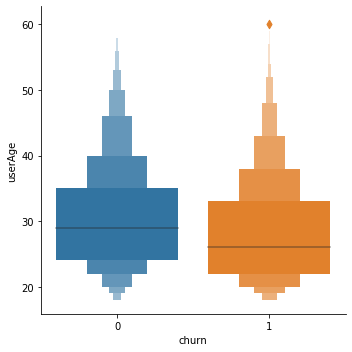

In [48]:
# Using good quality data to check cutomer's age distribution by churn behavior

sns.catplot(data=reg[((reg['userAge']>=18) & (reg['userAge']<=60))], x='churn', y='userAge', kind='boxen')

# looks like median age of churned customers is lower than that of renewed customers

In [49]:
# Using good quality data to check cutomer's churn behavior by age
# Do younger customers have higher churn rate that elder ones?

piv = reg[(reg['userAge']>=18) & (reg['userAge']<=60)].groupby(['churn','userAge'])['msno'].count().unstack('churn').fillna(0).astype(int)
piv.columns = ['renew','churn']
piv['churnPct'] = (piv['churn'].div(piv.sum(1)) * 100).astype(int)
piv[piv[['renew','churn']].sum(1)>200].sort_values('churnPct', ascending=False).head(10)

,renew,churn,churnPct
userAge,,,
18,996,203,16
19,1229,239,16
20,1717,327,15
21,2052,332,13
22,2407,338,12
23,2658,305,10
24,2833,258,8
25,2960,263,8
52,230,21,8


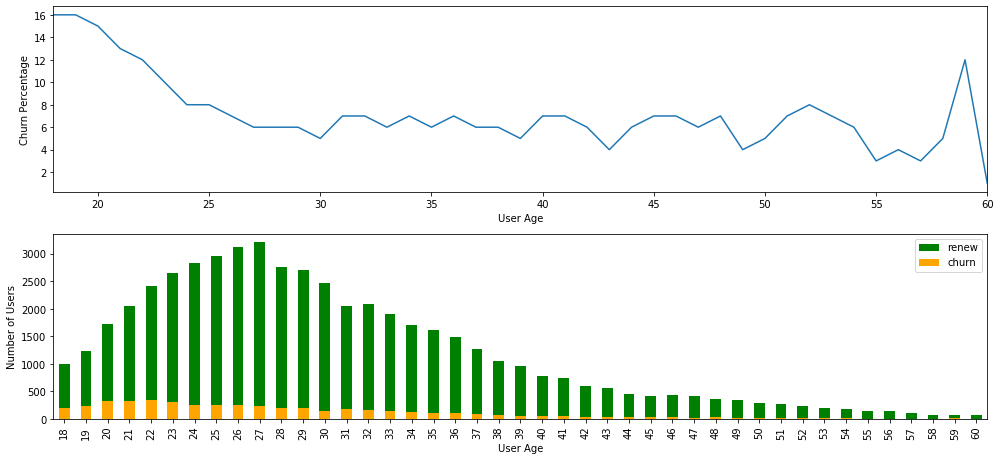

In [50]:
plt.figure(figsize=(14,6.5))

plt.subplot(2,1,1)
piv['churnPct'].plot()
plt.xlabel('User Age')
plt.ylabel('Churn Percentage')

plt.subplot(2,1,2)
piv['renew'].plot(kind='bar', stacked=True, color='green', legend='Renew')
piv['churn'].plot(kind='bar', stacked=True, color='orange', legend='Churn')
plt.xlabel('User Age')
plt.ylabel('Number of Users')

plt.tight_layout()

# users with age less than 22 show higher churn rate than ones beyond that age
# perhaps, age could be used in feature set for model training
# if that happens, records would need to be filtered for correct age range first (18 - 60 years)
# as a result, two models would need to be built - one with age attribute in the feature set and the other one without age
# however, if age is user-entered field, can we rely on its accuracy for future data?
# is it possible that users might be entering incorrect value even within conceivable range of 18-60 years?

In [51]:
# check DQ issue with member's gender

reg['gender'].value_counts(dropna=False)

# roughly half of the sample users have gender value missing
# since majority of data has missing value, imputation is not a solution

NaN       73515
male      31074
female    27918
Name: gender, dtype: int64

In [52]:
# using good quality data to check customers churn behavior by their gender

piv = reg.groupby(['churn','gender'])['msno'].count().unstack('churn').fillna(0).astype(int)
piv.columns = ['renew','churn']
piv['churnPct'] = (piv['churn'].div(piv.sum(1)) * 100).astype(int)
piv[piv[['renew','churn']].sum(1)>200].sort_values('churnPct', ascending=False)

# no difference in churn behavior by gender
# hence, fixing gender DQ issue is of no use, even if it were possible to do so for this high proportion of bad quality data

,renew,churn,churnPct
gender,,,
female,25528,2390,8
male,28343,2731,8


In [53]:
# check DQ issue with member's  registration source

reg['regSrc'].value_counts(dropna=False)

# looks like no issue here

7     73164
9     35603
3     15921
4      7374
13      445
Name: regSrc, dtype: int64

In [54]:
# check DQ issue with member's registration age

reg['regDate'].describe()

# it is fine to have users registered that far back in past
# what matters is that the transaction expiry date of each user is in Feb/Mar 2017
# and that it is in alignment with the max registration date as end of Feb 2017

count                  132507
unique                   4668
top       2015-10-09 00:00:00
freq                      256
first     2004-03-26 00:00:00
last      2017-03-26 00:00:00
Name: regDate, dtype: object

In [55]:
# outline years of registration for users

reg['regDate'].dt.year.value_counts(dropna=False)

2016    31228
2015    24534
2013    17530
2014    14055
2012    11701
2011     9572
2010     6073
2007     3943
2008     2716
2006     2647
2017     2561
2009     2338
2005     2304
2004     1305
Name: regDate, dtype: int64

In [56]:
# retain age attribute to be used later for alternate model building
# however, default all the values outside the reasonable range to one number that would be used to
# filter out bad records for alternate model training

reg['userAge'] = reg['userAge'].apply(lambda x: 1 if (x>60 or x<18) else x)
reg['userAge'].describe()

count    132507.000000
mean         13.503030
std          15.381247
min           1.000000
25%           1.000000
50%           1.000000
75%          27.000000
max          60.000000
Name: userAge, dtype: float64

In [57]:
# drop gender attribute due to high DQ issue

reg.drop('gender', axis=1, inplace=True)

In [58]:
# calculate registration age for the user i.e. number of days since the user registered for the service

reg['regAge'] = (currDate - reg['regDate']).dt.days + 1

In [59]:
# re-order attributes in the dataframe

reg = reg[['msno', 'churn', 'regDate', 'regAge', 'userAge', 'city', 'regSrc']]

reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132507 entries, 0 to 132506
Data columns (total 7 columns):
msno       132507 non-null object
churn      132507 non-null int64
regDate    132507 non-null datetime64[ns]
regAge     132507 non-null int64
userAge    132507 non-null int64
city       132507 non-null int64
regSrc     132507 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 7.1+ MB


In [60]:
# generate feed of clean data to be used later for EDA

reg.to_csv("{}/{}".format(dirData, fileCleanReg), index=False)

In [77]:
# delete registration and transaction dataframes to free up memory

del(reg)
del(trx)

#### Usage Data

In [61]:
# information about raw usage dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37112323 entries, 0 to 37112322
Data columns (total 10 columns):
msno          object
date          datetime64[ns]
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    int64
churn         int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.8+ GB


In [7]:
# tidy up usage data

# rename columns
df.rename({'is_churn':'churn', 'num_25':'songs25', 'num_50':'songs50', 'num_75':'songs75',
           'num_985':'songs985', 'num_100':'songs100', 'num_unq':'songsUnq'}, axis=1, inplace=True)

# convert playtime from float to integer type
df['total_secs'] = df['total_secs'].round().astype(int)

# derive a column to represent total number of songs played in a day (could very well include same songs played again)
df['songs'] = df['songs25'] + df['songs50'] + df['songs75'] + df['songs985'] + df['songs100']

# no. of unique songs played as percentage of total number of songs played
df['songsUnqPct'] = (df['songsUnq'].div(df['songs'], axis=0) * 100).fillna(0).round(1)

# derive attributes to represent songs replayed, completed and skipped as percentage of total songs played
df['songsRpl'] = df['songs'] - df['songsUnq']
df['songsRplPct'] = (df['songsRpl'].div(df['songs'], axis=0) * 100).fillna(0).round(1)
df['songsCmplPct'] = (df['songs100'].div(df['songs'], axis=0) * 100).fillna(0).round(1)
df['songsSkp'] = df['songs'] - df['songs100']
df['songsSkpPct'] = (df['songsSkp'].div(df['songs']) * 100).round(1)

# derive date related attributes to be used later
df = df.merge(dates[['date','year','week','yrWk']], on='date', sort=False)

df.head()

,msno,date,songs25,songs50,songs75,songs985,songs100,songsUnq,total_secs,churn,songs,songsUnqPct,songsRpl,songsRplPct,songsCmplPct,songsSkp,songsSkpPct,year,week,yrWk
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2015-01-01,3,3,2,2,6,16,2269,0,16,100.0,0,0.0,37.5,10,62.5,2015,1,201501
1,++4cUL0b9CfW8cj0A/wfSxQc4k4fcVtWcLqk2UOdpKs=,2015-01-01,0,0,0,0,5,5,1236,0,5,100.0,0,0.0,100.0,0,0.0,2015,1,201501
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,2015-01-01,21,0,0,1,13,33,3211,0,35,94.3,2,5.7,37.1,22,62.9,2015,1,201501
3,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,2015-01-01,2,1,1,0,19,14,5645,0,23,60.9,9,39.1,82.6,4,17.4,2015,1,201501
4,++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=,2015-01-01,4,2,0,4,19,15,5755,0,29,51.7,14,48.3,65.5,10,34.5,2015,1,201501


In [8]:
# information about tidy dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37112323 entries, 0 to 37112322
Data columns (total 20 columns):
msno            object
date            datetime64[ns]
songs25         int64
songs50         int64
songs75         int64
songs985        int64
songs100        int64
songsUnq        int64
total_secs      int32
churn           int64
songs           int64
songsUnqPct     float64
songsRpl        int64
songsRplPct     float64
songsCmplPct    float64
songsSkp        int64
songsSkpPct     float64
year            int64
week            int64
yrWk            int64
dtypes: datetime64[ns](1), float64(4), int32(1), int64(13), object(1)
memory usage: 5.7+ GB


In [64]:
# any missing value?

df.isnull().values.any()

False

In [65]:
# confirm the scope of dates; max date should be in Feb 2017, since we need to predict churn for the month of Mar 2017

df['date'].min(), df['date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

In [66]:
# confirm that the weeks in each year are as expected - 2017 should have 8 or 9 weeks only

df.groupby(['year'])['week'].agg(['min','max','nunique'])

,min,max,nunique
year,,,
2015,1,53,53
2016,1,52,52
2017,1,9,9


In [9]:
%%time

# number of songs less than 0?

df[df[[c for c in df if c.startswith("songs")]]<0].dropna()

Wall time: 4min 59s


,msno,date,songs25,songs50,songs75,songs985,songs100,songsUnq,total_secs,churn,songs,songsUnqPct,songsRpl,songsRplPct,songsCmplPct,songsSkp,songsSkpPct,year,week,yrWk


In [78]:
# churn distribution in training data

train['churn'].value_counts(normalize=True)*100

0    93.568667
1     6.431333
Name: churn, dtype: float64

In [79]:
# churn distribution in usage data

df_churn_info = df[['msno','churn']].drop_duplicates()['churn']
(df_churn_info.value_counts()*100)/df_churn_info.count()

# churn distribution in usage data is slightly different from that in labeled data (aka training data) 
# because usage does not have all the users from labeled data

0    93.394102
1     6.605898
Name: churn, dtype: float64

In [80]:
# check that the number of unique songs is not greater than total number of songs listened to on the same day

df[df['songsUnq']>df['songs']]['msno'].count()

0

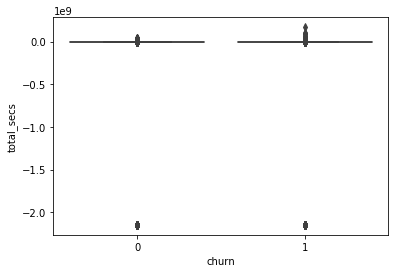

In [81]:
# distribution of playtime values

sns.boxplot(data=df, x='churn', y='total_secs')
plt.show()

# it seems that playtime has negative values
# does it also have values beyond 86400 secs, which is the maximum number of seconds available in a day?

In [82]:
# For how many records, playtime has data quality issue?

((df['total_secs']<0) | (df['total_secs']>86400)).sum()

# daily playtime value cannot be negative or greater than 86400 (total number of seconds in 24 hours)

18464

In [83]:
# How many users are affected with playtime data quality issue?

df[((df['total_secs']<0) | (df['total_secs']>86400))]['msno'].nunique()

6067

In [84]:
# average of playtime values

df['total_secs'].mean()

-306050.5135136111

In [85]:
# average of playtime values across normal range

df[((df['total_secs']>=0) & (df['total_secs']<=86400))]['total_secs'].mean()

# even though negligible percentage of total usage records has DQ issue, 
# the effect on the mean value is significant, implying that data with DQ issue certainly needs to be fixed

8037.589010110811

In [86]:
# correlation between playtime and songs played

df[['total_secs','songs100','songs']].corr()

,total_secs,songs100,songs
total_secs,1.000000,-0.007561,-0.009186
songs100,-0.007561,1.000000,0.926022
songs,-0.009186,0.926022,1.000000


In [87]:
# correlation between playtime and songs played for good quality data

df[(df['total_secs']>=0) & (df['total_secs']<=86400)][['total_secs','songs100','songs']].corr()

# clearly, playtime and songs completed in a day are highly correlated
# however, due to bad playtime values, the correlation seems to have been badly impacted (see results above)

,total_secs,songs100,songs
total_secs,1.000000,0.979715,0.934790
songs100,0.979715,1.000000,0.918465
songs,0.934790,0.918465,1.000000


Here are few ways of correcting the issue. 

However, I decide to use a hybrid methodology of first two – apply second where average value of the week exists and first if it doesn’t.

1)	Flooring and ceiling: Negative values are re-assigned 0, and ones beyond maximum allowable seconds in a day are updated as 86,400.

2)	Average of the week: Rectify the issue by replacing an abnormal value with the average value of the week the date belongs to.

3)	Average of the same days: Replace an abnormal value with the average value of the same days across user’s lifetime. Such a rectification is based on a reasonable theory that user's listening behavior must be more predictable by same days of the other weeks rather by other weekdays. For example, my listening behavior on a given Sunday might be more consistent with other Sundays rather than with Mondays or Thursdays.

4)	Total number of songs completed: A quick analysis reveals that normal playtime value for a given day is highly correlated with total number of songs completed by the user on the same day, with Pearson correlation coefficient of 0.98. Thereby, we can fix abnormal values by extrapolating numbers based on total number of songs listened to on the day.

In [10]:
# weekly playtime average (aggregated/reduced) data
# first filter out bad records for a clean average of playtime (total_secs) for each user (msno) and week/year

WkPlaytime = df[(df['total_secs']>=0) & (df['total_secs']<=86400)].groupby(['msno','year',
                                                                            'week'])['total_secs'].mean().reset_index()

In [11]:
# merge weekly average playtime with original dataset 

df['playtime_wk_mean'] = df[['msno','year','week','total_secs']].merge(WkPlaytime, on=['msno','year','week'], how='left',
                                                                        suffixes=('','_wk_mean'))['total_secs_wk_mean']

In [76]:
# alternate implementation of getting average weekly playtime in original dataframe
# however, the process takes much longer to get through (> 120 min.)

# df['playtime_wk_mean'] = df.groupby(['msno','year','week'])['total_secs'].transform(lambda x: x[(x>=0) & (x<=86400)].mean())

In [12]:
%%time

# derive "partially" cleaned-up playtime using average playtime for the corresponding user and week/year

df['playtime'] = df[['playtime_wk_mean','total_secs']].apply(lambda x: x['playtime_wk_mean'] if (x['total_secs']<0 or x['total_secs']>86400) else x['total_secs'], axis=1)

Wall time: 24min 17s


In [13]:
# replace null values (due to lack of averge playtime information for the given user and week) with 0 and 86400,
# depending on whether the original playtime is less than 0 or greater than 86400 respectively

df['playtime'] = df['playtime'].mask(pd.isnull, df['total_secs'].map(lambda x: 0 if x<0 else 86400 if x>86400 else -1)).round().astype(int)

In [14]:
# just check whether any playtime value was marked as -1 (from previous set of code)
# ideally, that shouldn't be the case

df[df['playtime']==-1]

,msno,date,songs25,songs50,songs75,songs985,songs100,songsUnq,total_secs,churn,...,songsRpl,songsRplPct,songsCmplPct,songsSkp,songsSkpPct,year,week,yrWk,playtime_wk_mean,playtime


In [15]:
# only the bad playtime values (total_secs) should have been fixed to and different from cleaned playtime values

(df['total_secs']!=df['playtime']).sum()

18464

In [16]:
# check that the playtime values are within the expected range of 0 and 86400

df['playtime'].min(), df['playtime'].max()

(0, 86400)

In [17]:
df[['total_secs','playtime','songs100','songs']].corr()

# total_secs is the raw attribute with DQ issues
# playtime is the new attribute after fixing the DQ issues
# notice the correlation between playtime and songs, and that between total_secs and songs

,total_secs,playtime,songs100,songs
total_secs,1.000000,-0.003100,-0.007561,-0.009186
playtime,-0.003100,1.000000,0.926609,0.895250
songs100,-0.007561,0.926609,1.000000,0.926022
songs,-0.009186,0.895250,0.926022,1.000000


In [18]:
# re-organize columns in the dataframe

df = df[['msno', 'churn', 'date', 'total_secs', 'playtime', 'songs', 'songs25', 'songs50', 'songs75', 'songs985', 
         'songs100', 'songsCmplPct', 'songsSkp', 'songsSkpPct', 'songsUnq', 'songsUnqPct', 'songsRpl', 'songsRplPct',
         'year', 'week', 'yrWk']]

df.head(3)

,msno,churn,date,total_secs,playtime,songs,songs25,songs50,songs75,songs985,...,songsCmplPct,songsSkp,songsSkpPct,songsUnq,songsUnqPct,songsRpl,songsRplPct,year,week,yrWk
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,2015-01-01,2269,2269,16,3,3,2,2,...,37.5,10,62.5,16,100.0,0,0.0,2015,1,201501
1,++4cUL0b9CfW8cj0A/wfSxQc4k4fcVtWcLqk2UOdpKs=,0,2015-01-01,1236,1236,5,0,0,0,0,...,100.0,0,0.0,5,100.0,0,0.0,2015,1,201501
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0,2015-01-01,3211,3211,35,21,0,0,1,...,37.1,22,62.9,33,94.3,2,5.7,2015,1,201501


In [19]:
df[['playtime', 'songs', 'songs25', 'songs50', 'songs75', 'songs985', 'songs100', 'songsCmplPct', 'songsSkp', 'songsSkpPct',
       'songsUnq', 'songsUnqPct', 'songsRpl', 'songsRplPct']].corr()

,playtime,songs,songs25,songs50,songs75,songs985,songs100,songsCmplPct,songsSkp,songsSkpPct,songsUnq,songsUnqPct,songsRpl,songsRplPct
playtime,1.000000,0.895250,0.183784,0.178203,0.226048,0.238732,0.926609,0.299944,0.239116,-0.299944,0.804454,-0.267998,0.603594,0.267998
songs,0.895250,1.000000,0.467607,0.347190,0.362533,0.305978,0.926022,0.123647,0.514687,-0.123647,0.846849,-0.258196,0.739676,0.258196
songs25,0.183784,0.467607,1.000000,0.472979,0.421965,0.275213,0.124098,-0.383375,0.942339,0.383375,0.492806,-0.062225,0.223374,0.062225
songs50,0.178203,0.347190,0.472979,1.000000,0.633294,0.271299,0.095760,-0.298717,0.691450,0.298717,0.374213,-0.051235,0.155331,0.051235
songs75,0.226048,0.362533,0.421965,0.633294,1.000000,0.373085,0.140914,-0.268553,0.629056,0.268553,0.370007,-0.087921,0.188443,0.087921
songs985,0.238732,0.305978,0.275213,0.271299,0.373085,1.000000,0.150466,-0.197467,0.459296,0.197467,0.309710,-0.076842,0.162307,0.076842
songs100,0.926609,0.926022,0.124098,0.095760,0.140914,0.150466,1.000000,0.324697,0.152977,-0.324697,0.737925,-0.262537,0.743512,0.262537
songsCmplPct,0.299944,0.123647,-0.383375,-0.298717,-0.268553,-0.197467,0.324697,1.000000,-0.413798,-1.000000,0.087411,-0.094095,0.113350,0.094095
songsSkp,0.239116,0.514687,0.942339,0.691450,0.629056,0.459296,0.152977,-0.413798,1.000000,0.413798,0.540974,-0.079646,0.247698,0.079646
songsSkpPct,-0.299944,-0.123647,0.383375,0.298717,0.268553,0.197467,-0.324697,-1.000000,0.413798,1.000000,-0.087411,0.094095,-0.113350,-0.094095


In [54]:
%%time

# dump the clean daily usage data onto a file for later use

df.to_csv("{}/{}".format(dirData, fileCleanUsg), index=False)

Wall time: 2h 24min 5s


## Data Manipulation

Since sales transaction and usage data are not at the user level, we need to aggregate them accordingly.

For sales transactions, we focus on the last sales transaction for each user, ignoring all the previous transactions.

For usage data, we aggregate the data into two separate datasets - first one prepares lifetime usage stats/metrics at user level, while the second one formulates recent, near past and lifetime usage stats/metrics at user level. Both the datasets will help in EDA later.

In [21]:
## import all the datasets

# labeled aka training data
train = pd.read_csv("{}/{}".format(dirData, fileSampleTrn))

# clean sales/subscription transaction data
trx = pd.read_csv("{}/{}".format(dirData, fileCleanTrx), parse_dates=['trxDate','expDate'])

# clean registration/membership data
reg = pd.read_csv("{}/{}".format(dirData, fileCleanReg), usecols=['msno','churn','regAge','userAge','city','regSrc'])

# clean daily usage data
df = pd.read_csv("{}/{}".format(dirData, fileCleanUsg), parse_dates=['date'])

# dates dimension data
dates = pd.read_csv("{}/{}".format(dirData, fileDates), parse_dates=['date'])

In [22]:
# save minimum and maximum dates in scope of usage data

startDate = dates['date'].min()
currDate = dates['date'].max()

print(startDate, currDate)

2015-01-01 00:00:00 2017-02-28 00:00:00


#### Last Sales Transaction

In [23]:
# aggregate sales transactions at user level while retaining information of only last transaction
lstrx = trx.groupby(['msno','churn']).last().reset_index()

# calculate number of days since last transaction
lstrx['daysLastTrx'] = (currDate - lstrx['trxDate']).dt.days + 1

# drop useless attributes
lstrx.drop(['trxDate','expDate','planListPrice','paidAmt'], axis=1, inplace=True)

In [24]:
# verify that the grain of the data is user id

lstrx[lstrx.duplicated(['msno'])]

,msno,churn,cancel,autoRenew,payMethod,planTerm,discAmt,daysLastTrx


In [25]:
lstrx[lstrx['msno']==demUsr]

,msno,churn,cancel,autoRenew,payMethod,planTerm,discAmt,daysLastTrx
12530,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,0,1,41,30,0,47


In [26]:
# save the data to be used for EDA later

lstrx.to_csv("{}/{}".format(dirData, fileLastTrx), index=False)

#### Aggregated Lifetime Usage Data for Active Days

Aggregate lifetime daily usage data at user level for only active days i.e. days when the user logged into the service and used it

In [27]:
# not using playtime as it is highly correlated to songs completed (songs100) and total number of songs, and had some DQ issues

adf = df.groupby(['msno','churn'])[['date', 'songs', 'songs25', 'songs50', 'songs75', 'songs985',
                                    'songs100', 'songsCmplPct', 'songsSkp', 'songsSkpPct', 'songsUnq', 
                                    'songsUnqPct', 'songsRpl', 'songsRplPct']].agg({'date':['min','max','count'],
                                    'songs':['sum','mean'],
                                    'songs25':['sum','mean'], 'songs50':['sum','mean'], 'songs75':['sum','mean'],
                                    'songs985':['sum','mean'], 
                                    'songs100':['sum','mean'], 'songsCmplPct':'mean',
                                    'songsSkp':['sum','mean'], 'songsSkpPct':'mean', 
                                    'songsUnq':['sum','mean'], 'songsUnqPct':'mean', 
                                    'songsRpl':['sum','mean'], 'songsRplPct':'mean'
                                    }).reset_index().round(1)

# rename columns

adf.columns=['msno', 'churn', 'minDate', 'maxDate', 'daysActive', 
             'songs', 'songsPerActiveDay',
             'songs25', 'songs25PerActiveDay', 'songs50', 'songs50PerActiveDay',
             'songs75', 'songs75PerActiveDay', 'songs985', 'songs985PerActiveDay',
             'songsCmpl', 'songsCmplPerActiveDay', 'songsCmplPctPerActiveDay',
             'songsSkp', 'songsSkpPerActiveDay', 'songsSkpPctPerActiveDay',
             'songsUnq', 'songsUnqPerActiveDay', 'songsUnqPctPerActiveDay',
             'songsRpl', 'songsRplPerActiveDay', 'songsRplPctPerActiveDay']

# derive days since first login from Jan 1, 2015 onwards
adf['daysFirstLogin'] =  (currDate - adf['minDate']).dt.days + 1
# not using it later for model building as the earliet data of usage data available is 2015-01-01
# so even if a user started using the service before 2015, we don't have his usage logs
# as a result, days since first login is not the correct parameter to assess churn behavior

# derive days since last login 
adf['daysLastLogin'] =  (currDate - adf['maxDate']).apply(lambda x: x.days + 1)

# calculate proportion of days user has been active for, since Jan 1, 2015
adf['daysActivePct'] = (adf['daysActive'].div(adf['daysFirstLogin'], axis=0) * 100).fillna(0).round(1)

# adf['songsCmplPct'] = (adf['songsCmpl'].div(adf['songs'], axis=0) * 100).fillna(0).round(1)
# metrics corresponding to number of songs completed/skipped/replayed as percentage of 
# total number of songs listened to during entirety of usage till date
# none of such derived attributes seem to have any correlation with churn behavior

# retain relevant attributes for further analysis

adf = adf[['msno', 'churn', 'daysLastLogin',
           'daysActive', 'daysActivePct',
           'songs', 'songsPerActiveDay', 
           'songsCmpl', 'songsCmplPerActiveDay',
           'songsSkp', 'songsSkpPerActiveDay',
           'songsUnq', 'songsUnqPerActiveDay',
           'songsRpl', 'songsRplPerActiveDay',
           'songs25','songs25PerActiveDay', 'songs50','songs50PerActiveDay',
           'songs75','songs75PerActiveDay','songs985','songs985PerActiveDay'
          ]]

In [28]:
# verify that the grain of the data is user id

adf[adf.duplicated(['msno'])]

,msno,churn,daysLastLogin,daysActive,daysActivePct,songs,songsPerActiveDay,songsCmpl,songsCmplPerActiveDay,songsSkp,...,songsRpl,songsRplPerActiveDay,songs25,songs25PerActiveDay,songs50,songs50PerActiveDay,songs75,songs75PerActiveDay,songs985,songs985PerActiveDay


In [29]:
adf[adf['msno']==demUsr]

,msno,churn,daysLastLogin,daysActive,daysActivePct,songs,songsPerActiveDay,songsCmpl,songsCmplPerActiveDay,songsSkp,...,songsRpl,songsRplPerActiveDay,songs25,songs25PerActiveDay,songs50,songs50PerActiveDay,songs75,songs75PerActiveDay,songs985,songs985PerActiveDay
10998,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,1,160,51.0,12064,75.4,10262,64.1,1802,...,3389,21.2,1404,8.8,154,1.0,135,0.8,109,0.7


In [30]:
# save the data to be used for EDA later

adf.to_csv("{}/{}".format(dirData, fileUsgAggLifetime), index=False) 

#### Aggregated Lifetime and Recent Usage Data 

Before we can visualize data, in EDA later, to see how churn and renew users behaved over time, we need to aggregate day-level usage data to week-level while wrangling it to show null usage even for weeks when user did not use the service at all.

In [31]:
# build weeks dimension dataset - get distinct combinations of year and week from usage dataset

weeks = pd.DataFrame(dates['yrWk'].unique(), columns=['yrWk']).sort_values('yrWk')
weeks = weeks.reset_index(drop=True).reset_index()
weeks.columns= ['yrWkIdx','yrWk']
weeks['yrWkIdx'] = weeks['yrWkIdx'] + 1

# dummy variable to be used for cross-join purposes only
weeks['key'] = 0

# confirm that the number of combinations of year and weeks are 114 (from Jan 2015 to Feb 2017)
print(weeks['yrWk'].count() == 114)

print('\n', weeks.head())

True

    yrWkIdx    yrWk  key
0        1  201501    0
1        2  201502    0
2        3  201503    0
3        4  201504    0
4        5  201505    0


In [32]:
# aggregate usage data at week level, showcasing only the weeks user leveraged the service for

dfwk = df.groupby(['msno', 'churn', 'yrWk'])['date', 'songs',
                                             'songsRpl'].agg({'date':'count',
                                                              'songs':'sum', 'songsRpl':'sum'}).astype('int').reset_index()
# not including playtime because of DQ issue/fix and because of high correlation with songs
# not including songs25 because of high correlation with songsSkp 
# not including songs100 and songsUnq because of high correlation with songs
# not including songs50, songs75, songs985 and songsSkp as they do not show any importance later

# rename columns to tidy up the data
dfwk.columns = ['msno', 'churn', 'yrWk', 'daysActive', 'songs', 'songsRpl']

# derive yrWkIdx attribute by joining with weeks dataframe
dfwk = dfwk.merge(weeks.drop('key', axis=1), on='yrWk', how='inner')

# put attributes in a sensible order
dfwk = dfwk[['msno', 'churn', 'yrWkIdx', 'yrWk', 'daysActive', 'songs', 'songsRpl']]

print('# users in dfwk dataframe:', dfwk['msno'].nunique())

# users in dfwk dataframe: 131428


In [33]:
dfwk[dfwk['msno']==demUsr].head(10)

# notice the gap between week 201621 and 201642
# this gap will be filled later with relevant records

,msno,churn,yrWkIdx,yrWk,daysActive,songs,songsRpl
4010798,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,201616,2,21,2
4089103,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,70,201617,7,337,86
4167937,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,71,201618,6,265,21
4247442,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,72,201619,6,137,44
4327881,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,73,201620,3,87,25
4408887,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,74,201621,6,172,79
6235477,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,95,201642,7,234,50
6329083,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,96,201643,7,368,58
6423327,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,97,201644,7,755,232
6518408,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,98,201645,7,583,120


In [34]:
# get first and last login week for each user
rangeWk = dfwk.groupby(['msno','churn'])[['yrWkIdx', 'yrWk']].agg(['min', 'max']).reset_index()

# rename columns
rangeWk.columns = ['msno', 'churn', 'startYrWkIdx', 'endYrWkIdx', 'startYrWk', 'endYrWk']

# dummy variable to be used for cross-join purposes only
rangeWk['key'] = 0 

print('# users in rangeWk dataframe:', rangeWk['msno'].count())

# users in rangeWk dataframe: 131428


In [35]:
rangeWk[rangeWk['msno']==demUsr]

,msno,churn,startYrWkIdx,endYrWkIdx,startYrWk,endYrWk,key
10998,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,0


In [36]:
# creating a table with user and week/year values since the week user started using service
# until current week i.e. till last week of usage data

# cartesian join of user and all 114 week/year values
mswk = pd.merge(rangeWk, weeks, how='inner', on='key').drop('key', axis=1).sort_values(['msno','yrWk'])

# confirm that each user has exactly 114 week/year values (from Jan 2015 through Feb 2017) 
print("Any user has more than 114 records?\n", mswk.groupby('msno').filter(lambda x: len(x)!=114))

# filter out records with months before the first usage week 
mswk = mswk[(mswk['yrWk']>=mswk['startYrWk'])]
#mswk = mswk[(mswk['yrWk']>=mswk['startYrWk']) & (mswk['yrWk']<=mswk['endYrWk'])]

Any user has more than 114 records?
 Empty DataFrame
Columns: [msno, churn, startYrWkIdx, endYrWkIdx, startYrWk, endYrWk, yrWkIdx, yrWk]
Index: []


In [37]:
mswk[mswk['msno']==demUsr]

,msno,churn,startYrWkIdx,endYrWkIdx,startYrWk,endYrWk,yrWkIdx,yrWk
1253840,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,69,201616
1253841,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,70,201617
1253842,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,71,201618
1253843,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,72,201619
1253844,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,73,201620
1253845,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,74,201621
1253846,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,75,201622
1253847,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,76,201623
1253848,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,77,201624
1253849,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,114,201616,201709,78,201625


In [38]:
# function to figure out streak of non-usage later

def streaks(df, col):
    sign = np.sign(df[col])
    s = sign.groupby((sign!=sign.shift()).cumsum()).cumsum()
    return df.assign(noUsgStrk=s.where(s>0, 0.0))#, d_streak=s.where(s<0, 0.0).abs())

In [39]:
# aggregate usage data at user and week level, since the week he started using the service;
# retain even weeks (since start week) when he did not use the service at all - henceforth identified by noUsg attribute

# left join user-week combinations with weekly-aggregated usage data
dfaw = mswk.merge(dfwk, on=['msno','churn','yrWkIdx','yrWk'], how='left').fillna(0).reset_index(drop=True)

# convert attributes data type
dfaw[['daysActive', 'songs', 'songsRpl']] = dfaw[['daysActive', 'songs', 'songsRpl']].astype('int')

# derive a flag to indicate if the user did not use service at all during the week
dfaw['noUsg'] = dfaw['daysActive'].apply(lambda x: 1 if x==0 else 0)

# calculate streak for null usage - number of weeks of continuous no usage
dfaw = streaks(dfaw, 'noUsg')

# retain relevant columns only
dfaw = dfaw[['msno', 'churn', #'startYrWkIdx', 'startYrWk',
             'yrWkIdx', 'yrWk', 'daysActive', 'songs', # 'songsRpl',
             'noUsg', 'noUsgStrk']]

print('# users in dfaw dataframe:', dfaw['msno'].nunique())

# users in dfaw dataframe: 131428


In [40]:
dfaw[dfaw['msno']==demUsr]

# notice (in below output) 0 values for weeks user did not use the service at all

,msno,churn,yrWkIdx,yrWk,daysActive,songs,noUsg,noUsgStrk
862297,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,69,201616,2,21,0,0
862298,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,70,201617,7,337,0,0
862299,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,71,201618,6,265,0,0
862300,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,72,201619,6,137,0,0
862301,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,73,201620,3,87,0,0
862302,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,74,201621,6,172,0,0
862303,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,75,201622,0,0,1,1
862304,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,76,201623,0,0,1,2
862305,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,77,201624,0,0,1,3
862306,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,78,201625,0,0,1,4


Now that we have week level data for each user since the week he started using the service, we can aggregate stats and build metrics for different time periods. This would help later in EDA to analyze difference in usage trends over time for churn vs. renew users.

In [41]:
# define a function to aggregate weekly usage metrics at user level for given weeks in past

def aggUsgGivenWks(df, n=2):
# aggregate week-level usage data to user-level for last n weeks
# if n=0, then aggrgeation happens on lifetime usage

    if n==0: # lifetime usage
        dfgrp = df.groupby(['msno','churn'])
    else:
        dfgrp = df.groupby(['msno','churn']).tail(n).groupby(['msno','churn'])
    
    dfagg = dfgrp[['yrWk', 'daysActive', 'songs',
                   'noUsg', 'noUsgStrk']].agg({'yrWk':'count', 'daysActive':'mean', 'songs':'mean',
                                               'noUsg':'sum', 'noUsgStrk':'max'})
    
    dfagg.columns=['weeks','daysActivePerWk','songsPerWk','noUsgWks','noUsgStrkMax']
    
    dfagg['noUsgPct'] = dfagg['noUsgWks'].div(dfagg['weeks'])
    
    return dfagg.reset_index()

In [42]:
# limit usage data to users who started using the service at least 8 weeks back
# so that we have some amount of data to look into their "recent" behavior

dfawltd = dfaw.groupby(['msno','churn']).filter(lambda x: len(x)>8)

print('# users in dfawltd dataframe:', dfawltd['msno'].nunique())

# users in dfawltd dataframe: 128294


In [43]:
# aggregate weekly usage metrics at user level for given weeks in past
# to try out if there was dip in immediate-past usage vs. near-past/lifetime usage

# no limitation on number of weeks i.e. aggregate lifetime usage data
dfaggLf   = aggUsgGivenWks(dfawltd, 0)

# aggregate last 2 weeks of usage data - immediate-past usage
dfaggIp  = aggUsgGivenWks(dfawltd, 2).drop(['noUsgPct','noUsgStrkMax'], axis=1)

# aggregate last 8 weeks of usage data - near-past usage
dfaggNp  = aggUsgGivenWks(dfawltd, 8).drop(['noUsgPct','noUsgStrkMax'], axis=1)

In [44]:
# function to derive percentage change for a metric between two time-frames

def derivePctChange(df, metric='daysActivePerWk', between=['Ip','Np']):
    if between[1]=='Lf':
        df['{}%Chg{}{}'.format(metric, between[0], between[1])] = ((df['{}{}'.format(metric, between[0])] - df['{}'.format(metric)]).div(df['{}'.format(metric)])).fillna(0)
    else:
        df['{}%Chg{}{}'.format(metric, between[0], between[1])] = ((df['{}{}'.format(metric, between[0])] - df['{}{}'.format(metric, between[1])]).div(df['{}{}'.format(metric, between[1])])).fillna(0)
    return df

In [45]:
# join different time-period's usage metrics in one dataset to derive usage trend overtime

# join immediate-past usage metrics with near-past usage metrics
dfagg = dfaggIp.merge(dfaggNp, on=['msno','churn'], how='inner', suffixes=('Ip','Np')) 
# abbreviate immediate-past as "Ip" and near-past as "Np"

# join immediate-past and near-past usage metrics with lifetime usage metrics
dfagg = dfagg.merge(dfaggLf, on=['msno','churn'], how='inner', suffixes=('','Lf')) 
# abbreviate lifetime usage as "Lf"
# remember Lf suffix isn't applied here, since the names are not common among Ip/Np metrics and lifetime metrics

# derive % change in usage metrics - immediate-past vs. near-past
dfagg = derivePctChange(dfagg, 'daysActivePerWk', ['Ip','Np'])
dfagg = derivePctChange(dfagg, 'songsPerWk', ['Ip','Np'])

# derive % change in usage metrics - immediate-past vs. lifetime
dfagg = derivePctChange(dfagg, 'daysActivePerWk', ['Ip','Lf'])
dfagg = derivePctChange(dfagg, 'songsPerWk', ['Ip','Lf'])

# derive % change in usage metrics - near-past vs. lifetime
dfagg = derivePctChange(dfagg, 'daysActivePerWk', ['Np','Lf'])
dfagg = derivePctChange(dfagg, 'songsPerWk', ['Np','Lf'])

# re-organize list of columns
dfagg = dfagg[['msno', 'churn',
               'weeks',  'noUsgWks', 'noUsgPct',  'noUsgStrkMax', 'daysActivePerWk', 'songsPerWk',
               'weeksIp', 'noUsgWksIp', 'daysActivePerWkIp', 'songsPerWkIp', 
               'weeksNp', 'noUsgWksNp', 'daysActivePerWkNp', 'songsPerWkNp',
               'daysActivePerWk%ChgIpNp', 'songsPerWk%ChgIpNp', 
               'daysActivePerWk%ChgIpLf', 'songsPerWk%ChgIpLf',
               'daysActivePerWk%ChgNpLf', 'songsPerWk%ChgNpLf'
              ]]

# rename list of columns
dfagg.columns = ['msno', 'churn',
                 'weeksLf',  'noUsgWksLf', 'noUsgPctLf',  'noUsgStrkMaxLf', 'daysActivePerWkLf', 'songsPerWkLf',
                 # notice that usage metrics for lifetime are suffixed with Lf now
                 'weeksIp', 'noUsgWksIp', 'daysActivePerWkIp', 'songsPerWkIp', 
                 'weeksNp', 'noUsgWksNp', 'daysActivePerWkNp', 'songsPerWkNp',
                 'daysActivePerWk%ChgIpNp', 'songsPerWk%ChgIpNp',
                 'daysActivePerWk%ChgIpLf', 'songsPerWk%ChgIpLf',
                 'daysActivePerWk%ChgNpLf', 'songsPerWk%ChgNpLf'
                ]

dfagg.head(2)

,msno,churn,weeksLf,noUsgWksLf,noUsgPctLf,noUsgStrkMaxLf,daysActivePerWkLf,songsPerWkLf,weeksIp,noUsgWksIp,...,weeksNp,noUsgWksNp,daysActivePerWkNp,songsPerWkNp,daysActivePerWk%ChgIpNp,songsPerWk%ChgIpNp,daysActivePerWk%ChgIpLf,songsPerWk%ChgIpLf,daysActivePerWk%ChgNpLf,songsPerWk%ChgNpLf
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,114,0,0.0,0,5.289474,312.157895,2,0,...,8,0,4.875,184.500,-0.179487,-0.298103,-0.243781,-0.585146,-0.078358,-0.408953
1,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,51,0,0.0,0,5.725490,152.941176,2,0,...,8,0,5.625,110.625,-0.200000,-0.407910,-0.214041,-0.571731,-0.017551,-0.276683


In [46]:
# verify that the grain of the data is user id

dfagg[dfagg.duplicated(['msno'])]

,msno,churn,weeksLf,noUsgWksLf,noUsgPctLf,noUsgStrkMaxLf,daysActivePerWkLf,songsPerWkLf,weeksIp,noUsgWksIp,...,weeksNp,noUsgWksNp,daysActivePerWkNp,songsPerWkNp,daysActivePerWk%ChgIpNp,songsPerWk%ChgIpNp,daysActivePerWk%ChgIpLf,songsPerWk%ChgIpLf,daysActivePerWk%ChgNpLf,songsPerWk%ChgNpLf


In [47]:
dfagg[dfagg['msno']==demUsr]

,msno,churn,weeksLf,noUsgWksLf,noUsgPctLf,noUsgStrkMaxLf,daysActivePerWkLf,songsPerWkLf,weeksIp,noUsgWksIp,...,weeksNp,noUsgWksNp,daysActivePerWkNp,songsPerWkNp,daysActivePerWk%ChgIpNp,songsPerWk%ChgIpNp,daysActivePerWk%ChgIpLf,songsPerWk%ChgIpLf,daysActivePerWk%ChgNpLf,songsPerWk%ChgNpLf
10735,3Jyl3B1cP+CYYgpEZRDwq5huDkB9qfNOqq3Lt1JYfXE=,0,46,20,0.434783,20,3.478261,262.26087,2,0,...,8,0,6.125,513.0,-0.346939,-0.41423,0.15,0.145806,0.760938,0.956068


In [48]:
# save the data to be used for EDA later

dfagg.to_csv("{}/{}".format(dirData, fileUsgAggPeriods), index=False)

### Building Feature Set

Based on results of Exploratory Data Analysis, we join various user-level datasets and create one denormalized dataset containing all the potential features to be used later for statistical model training and testing later.

In [49]:
# count of users in each of the user-level dataset

train['msno'].nunique(), lstrx['msno'].nunique(), reg['msno'].nunique(), adf['msno'].nunique(), dfagg['msno'].nunique()

# dfagg has lower number of users than adf because we filtered out users who had not been using the service for at least 8 weeks

(150000, 150000, 132507, 131428, 128294)

In [50]:
# creating one denormalized dataset with all the relevant metrics for each user

dnrm = lstrx.drop(['discAmt'], axis=1).merge(reg.drop('userAge', axis=1), on=['msno','churn'], how='inner')
dnrm = dnrm.merge(adf[['msno','churn','daysLastLogin']], on=['msno','churn'], how='inner')
dnrm = dnrm.merge(dfagg.drop(['weeksLf','weeksIp','weeksNp'], axis=1), on=['msno','churn'], how='inner')
dnrm = dnrm[dnrm['msno'].isin(train['msno'])]

dnrm['msno'].nunique()

128293

In [51]:
# renew-churn proportion in the denormalized feature set

dnrm['churn'].value_counts(normalize=True)

0    0.935406
1    0.064594
Name: churn, dtype: float64

In [52]:
print(dnrm.columns)

Index(['msno', 'churn', 'cancel', 'autoRenew', 'payMethod', 'planTerm',
       'daysLastTrx', 'regAge', 'city', 'regSrc', 'daysLastLogin',
       'noUsgWksLf', 'noUsgPctLf', 'noUsgStrkMaxLf', 'daysActivePerWkLf',
       'songsPerWkLf', 'noUsgWksIp', 'daysActivePerWkIp', 'songsPerWkIp',
       'noUsgWksNp', 'daysActivePerWkNp', 'songsPerWkNp',
       'daysActivePerWk%ChgIpNp', 'songsPerWk%ChgIpNp',
       'daysActivePerWk%ChgIpLf', 'songsPerWk%ChgIpLf',
       'daysActivePerWk%ChgNpLf', 'songsPerWk%ChgNpLf'],
      dtype='object')


In [53]:
dnrm.to_csv("{}/{}".format(dirData, fileDnrm), index=False)